In [ ]:
!pip install qdrant-client fastembed langchain-core langchain-community
!pip install pypdf
!pip install tiktoken
!pip install groq==0.9.0

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from qdrant_client import QdrantClient,models
import os
import tiktoken
from uuid import uuid4
from langchain_core.documents import Document
from groq import Groq

In [20]:
# !rm -rf dense
# !rm -rf hybrid
# !rm -rf hybrid-data

In [2]:
def num_tokens_from_string(string, encoding_name="cl100k_base"):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string("sample text")

2

In [3]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=100,
    chunk_overlap=10,
    length_function=num_tokens_from_string,
    is_separator_regex=True,
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
        "\u200b",  # Zero-width space
        "\uff0c",  # Fullwidth comma
        "\u3001",  # Ideographic comma
        "\uff0e",  # Fullwidth full stop
        "\u3002",  # Ideographic full stop
        "",
    ],
)

In [4]:
loader = PyPDFLoader("gemini.pdf")
list_of_documents = loader.load_and_split(text_splitter)
len(list_of_documents)

496

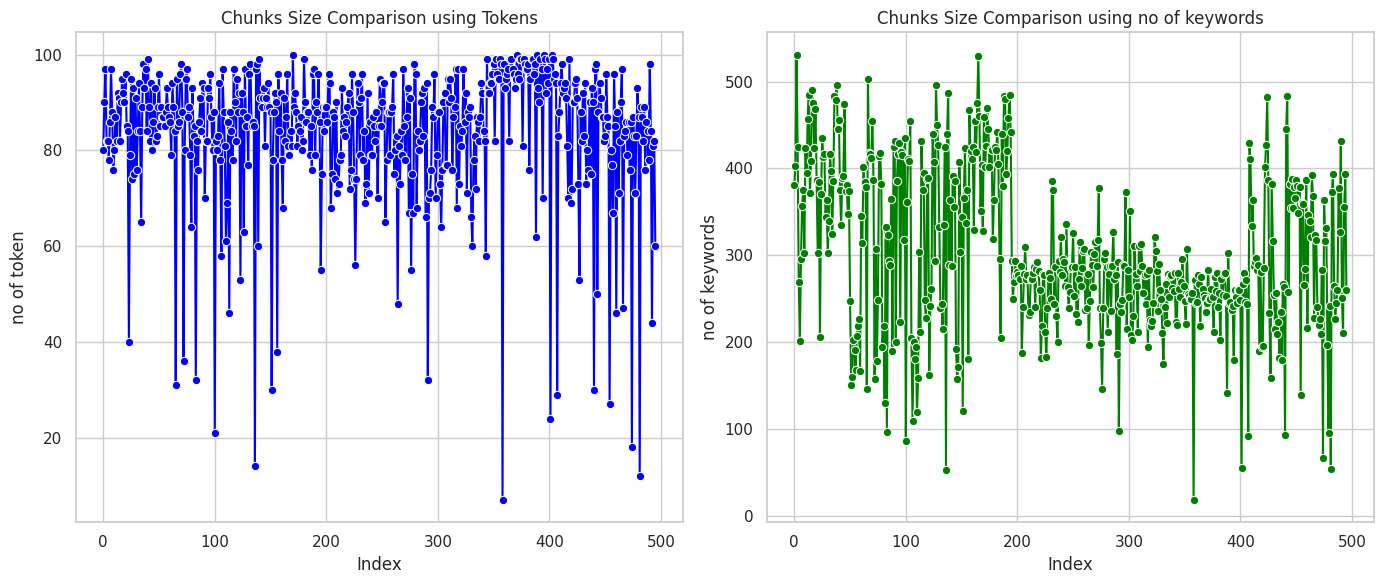

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your two lists of integers
token_count = [num_tokens_from_string(doc.page_content) for doc in list_of_documents]
length = [len(doc.page_content) for doc in list_of_documents]

# Set the style and create a figure with two subplots
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Left side plot for lst1
plt.subplot(1, 2, 1)
sns.lineplot(data=token_count, marker="o", color="blue")
plt.title('Chunks Size Comparison using Tokens')
plt.xlabel('Index')
plt.ylabel('no of token')

# Right side plot for lst2
plt.subplot(1, 2, 2)
sns.lineplot(data=length, marker="o", color="green")
plt.title('Chunks Size Comparison using no of keywords')
plt.xlabel('Index')
plt.ylabel('no of keywords')

# Show the plots
plt.tight_layout()
plt.show()

In [2]:
client = QdrantClient(path="hybrid")

In [22]:
client.set_model("BAAI/bge-base-en-v1.5")
# comment this line to use dense vectors only
client.set_sparse_model("prithivida/Splade_PP_en_v1")

In [23]:
client.get_fastembed_vector_params()

{'fast-bge-base-en-v1.5': VectorParams(size=768, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}

In [24]:
client.get_fastembed_sparse_vector_params()

{'fast-sparse-splade_pp_en_v1': SparseVectorParams(index=SparseIndexParams(full_scan_threshold=None, on_disk=None, datatype=None), modifier=None)}

In [25]:
uuids = [str(uuid4()) for _ in range(len(list_of_documents))]

metadata = [doc.metadata for doc in list_of_documents]
documents = [doc.page_content for doc in list_of_documents]

In [28]:
len(documents),len(metadata),len(uuids)

(496, 496, 496)

In [29]:
if not client.collection_exists("startups"):
    client.create_collection(
        collection_name="startups",
        vectors_config=client.get_fastembed_vector_params(),
        # comment this line to use dense vectors only
        sparse_vectors_config=client.get_fastembed_sparse_vector_params(),
    )

In [30]:
batch_size = 100
print("No of Batch -->",len(documents)//batch_size+1)
n = 0
for i in range(0,len(documents),batch_size):
  n+=1
  batch_documents = documents[i:i+batch_size]
  batch_uuids = uuids[i:i+batch_size]
  batch_metadata = metadata[i:i+batch_size]

  client.add(
    collection_name="startups",
    documents=batch_documents,
    metadata=batch_metadata,
    ids=batch_uuids,
    parallel=0,  # Use all available CPU cores to encode data.
  )
  print(f"Batch {n} Done")

No of Batch --> 5
Batch 1 Done
Batch 2 Done
Batch 3 Done
Batch 4 Done
Batch 5 Done


## Testing

In [ ]:
# Restart the kernel
import os
os.kill(os.getpid(), 9)

In [2]:
from qdrant_client import QdrantClient
class HybridSearcher:
    DENSE_MODEL = "BAAI/bge-base-en-v1.5"
    SPARSE_MODEL = "prithivida/Splade_PP_en_v1"
    def __init__(self, collection_name,only_dense):
        self.collection_name = collection_name
        # initialize Qdrant client
        self.qdrant_client = QdrantClient(path="hybrid")
        self.qdrant_client.set_model(self.DENSE_MODEL)
        # comment this line to use dense vectors only
        if not only_dense:
          self.qdrant_client.set_sparse_model(self.SPARSE_MODEL)
    def search(self, text: str):
      search_result = self.qdrant_client.query(
          collection_name=self.collection_name,
          query_text=text,
          query_filter=None,  # If you don't want any filters for now
          limit=3,  # 5 the closest results
      )
      # `search_result` contains found vector ids with similarity scores
      # along with the stored payload

      # Select and return metadata
      metadata = [hit.metadata for hit in search_result]
      return metadata

In [3]:
from google.colab import userdata
import os
from groq import Groq
groq_api_key = userdata.get('GROQ_API_KEY')
os.environ["GROQ_API_KEY"] = groq_api_key
groq_client = Groq()

In [4]:
def llm_call(query,context):
  final_data = ""
  for each_context in context:
    final_data += each_context['document'] +"-"*50

  user_prompt = f"""Below is the given context
  {final_data}
  Answer the following user question: {query}
  """
  sys_prompt = "You are a helpful assistant to give the answer of user question based on the given context"
  response = groq_client.chat.completions.create(
      messages = [
          {"role": "system", "content": sys_prompt},
          {"role": "user", "content": user_prompt}
      ],
      model = "llama-3.1-8b-instant"
  )
  output = response.choices[0].message.content
  return output

# Dense Search

In [5]:
query = 'In which tokenizer gemini is trained?'
hybrid_searcher = HybridSearcher(collection_name="startups",only_dense=True)
doc = hybrid_searcher.search(text=query)
doc

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

[{'document': 'Gemini: A Family of Highly Capable Multimodal Models\nJeff Stanway, Lorrayne Bennett, Demis Hassabis, Koray Kavukcuoglu, and Geoffrey Irving. Scaling\nlanguage models: Methods, analysis & insights from training Gopher. CoRR, abs/2112.11446,\n2021.',
  'source': 'gemini.pdf',
  'page': 30},
 {'document': '5.1.5. Long Context\nGemini models are trained with a sequence length of 32,768 tokens and we find that they make use\nof their context length effectively. We first verify this by running a synthetic retrieval test: we place\nkey-value pairs at the beginning of the context, then add long filler text, and ask for value associated\nwith a particular key. We find that the Ultra model retrieves the correct value with 98% accuracy',
  'source': 'gemini.pdf',
  'page': 9},
 {'document': 'We use the SentencePiece tokenizer (Kudo and Richardson, 2018) and find that training the\ntokenizer on a large sample of the entire training corpus improves the inferred vocabulary and\nsubse

### From dense search as we can see the last document is the retrieved document where answer is present

In [8]:
answer = llm_call(query=query,context=doc)
answer

'Gemini is trained using the SentencePiece tokenizer.'

# Hybrid Search

In [5]:
# Restart the kernel and then run
query = 'In which tokenizer gemini is trained?'
hybrid_searcher = HybridSearcher(collection_name="startups",only_dense=False)
doc = hybrid_searcher.search(text=query)
doc

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

[{'document': 'We use the SentencePiece tokenizer (Kudo and Richardson, 2018) and find that training the\ntokenizer on a large sample of the entire training corpus improves the inferred vocabulary and\nsubsequently improves model performance. For example, we find Gemini models can efficiently\ntokenize non-Latin scripts which can, in turn, benefit model quality as well as training and inference\nspeed.\nThe number of tokens used to train the largest models were determined following the approach',
  'source': 'gemini.pdf',
  'page': 4},
 {'document': '5.1.5. Long Context\nGemini models are trained with a sequence length of 32,768 tokens and we find that they make use\nof their context length effectively. We first verify this by running a synthetic retrieval test: we place\nkey-value pairs at the beginning of the context, then add long filler text, and ask for value associated\nwith a particular key. We find that the Ultra model retrieves the correct value with 98% accuracy',
  'source':

### As we can see by the help of hybrid search we can get more accurate result in this case first document is the answer document

In [6]:
answer = llm_call(query=query,context=doc)
answer

'Gemini is trained using the SentencePiece tokenizer.'